#CS F425 Deep Learning Assignment 1

By 

>Param Biyani (2019A7PS0059G) 

>Tanmay Devale (2019A7PS0066G)

>Vishal Vivek Bharambe (2019A7PS0160G)

Each member of the team showed equal contribution towards the assignment. 

Everyone contributed towards research, ideas, and implementation.


#Problem Statement

In this assignment we will explore the impact of
Skip Connections in Multi Layer Perceptron networks. Your tasks are to -
1. Compare the performance of MLPs with skip connections to those without skip
connections.
2. Analyse multiple different types of skip connections (at least 2) and compare their
performance.
3. Perform ablation studies over different (at least 2) characteristics of skip connections
(e.g. number of layers skipped) to see how this effects performance.
4. BONUS: Attempt to explain, through an experiment of your own, why Skip Connections help or hurt.

For training and performance evaluation in the above tasks use both CIFAR-10 and
MNIST.

##Setup

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [ ]:
# UI related imports
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
!pip install hiddenlayer
import hiddenlayer as hl
from torchviz import make_dot, make_dot_from_trace
from tqdm import tqdm
from torchsummary import summary

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-4h1ib3pw
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-4h1ib3pw
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4991 sha256=5c058c81cde20e826a118dc7a1cc9d8ace7abb9993b44b8d6c7f1718291e875c
  Stored in directory: /tmp/pip-ephem-wheel-cache-68p4ruqh/wheels/69/06/fd/652908d49c931cdcca96be3c727fb11ed777a3a62402210396
Successfully built torchviz


Loading and flattening MNIST and CIFAR10 datasets

In [ ]:
train_loader_MNIST = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),torchvision.transforms.Lambda(lambda x: torch.flatten(x))
                             ])),
  batch_size=256, shuffle=True)
test_loader_MNIST = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),torchvision.transforms.Lambda(lambda x: torch.flatten(x))
                             ])),
  batch_size=256, shuffle=False)
train_loader_CIFAR10 = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),torchvision.transforms.Lambda(lambda x: torch.flatten(x))
                             ])),
  batch_size=256, shuffle=True)
test_loader_CIFAR10 = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),torchvision.transforms.Lambda(lambda x: torch.flatten(x))
                             ])),
  batch_size=256, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /files/cifar-10-python.tar.gz to /files/
Files already downloaded and verified


Setting Device to GPU if possible

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Our accuracy calculating function. 

Takes in the model and the test loader file as input.

In [ ]:
def get_val_acc(modelToGetFrom, test_loader):
  correct,total = 0,0;
  for images,labels in test_loader:
    images = images.view(images.shape[0],-1).to(device)
    labels = labels.to(device)
    total += images.shape[0]
    out = modelToGetFrom(images)
    out = out.argmax(dim=1)
    correct += sum(out==labels)
  return correct/total

#Trainer
This is a function which can train the model for 20 epochs with a Cross Entropy Loss function, and Adam optimizer with learning rate of 0.0002.

As there can be a GPU, you can have your torch.device as cuda, hence we might need to transfer the images and labels to the device as well.

In [ ]:
def runner(model, train_loader, test_loader, learning_rate = 0.0002, criterion = torch.nn.CrossEntropyLoss()):

  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  losslist = []
  accuracies = []
  curBest=0
  for epoch in tqdm(range(20)):
      running_loss = 0
      for images, labels in train_loader:
          images = images.to(device)
    
          # Training pass
          optimizer.zero_grad()
          
          output = model(images)
          labels = labels.to(device)
          loss = criterion(output, labels)
          
          #This is where the model learns by backpropagating
          loss.backward()
          
          #And optimizes its weights here
          optimizer.step()
          
          running_loss += loss.item()
      
      val_acc =get_val_acc(model,test_loader)
      
      if (epoch+1) % 5 == 0:
        print("Epoch {} - Training loss: {} - val_acc: {}".format(epoch+1, running_loss/len(train_loader),val_acc))

      # Recording Loss and Accuracy values
      losslist.append(running_loss/len(train_loader))
      accuracies.append(val_acc)

  return losslist, accuracies

Buffer variable images for UI purposes

In [ ]:
images,labels = next(iter(test_loader_CIFAR10))
images = images.to(device)
images = images.view(images.shape[0],-1)

# Part 1 - Comparing Skipped vs Classic MLP

### MLP Class
This makes a normal MLP where a list of integers should be passed to the constructor including the input_size (i.e layers[0] ) . It has ReLU as it activation for all the layers except for the last layer which has softmax as its activation function to squeeze down all the values to probabilities.

In [ ]:
class MLP(torch.nn.Module):
  
    def __init__(self,layers):
        super(MLP, self).__init__()
        self.layers = layers
        self.layerAction = torch.nn.ModuleList()
        for i in range(len(layers)-1):
          self.layerAction.append(torch.nn.Linear(layers[i],layers[i+1]))

    def forward(self, x):
        output = x
        for i in range(len(self.layers) - 2):
          output = self.layerAction[i](output)
          output = torch.nn.functional.relu(output)
        output = self.layerAction[len(self.layerAction)-1](output)
        output = torch.nn.functional.softmax(output, dim=1)
        return output

### Declaring and training the normal MLP with 13 layers


In [ ]:
mlp_mnist = MLP([784,256,256,256,256,128,128,128,128,64,64,64,64,10])
mlp_mnist = mlp_mnist.to(device)

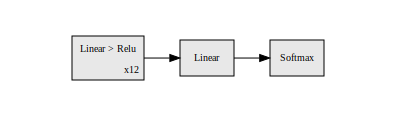

In [ ]:
mlp_cifar = MLP([32*32*3,256,256,256,256,128,128,128,128,64,64,64,64,10])
mlp_cifar = mlp_cifar.to(device)
hl.build_graph(mlp_cifar, images)

###Training for Unskipped

In [ ]:
# Training for MNIST
unskipped_loss_mnist, unskipped_acc_mnist = runner(mlp_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:11<03:34, 14.31s/it]

Epoch 5 - Training loss: 1.7648442963336377 - val_acc: 0.696399986743927


 50%|█████     | 10/20 [02:22<02:22, 14.23s/it]

Epoch 10 - Training loss: 1.7308791079419725 - val_acc: 0.7358999848365784


 75%|███████▌  | 15/20 [03:34<01:11, 14.32s/it]

Epoch 15 - Training loss: 1.7082270794726433 - val_acc: 0.754800021648407


100%|██████████| 20/20 [04:45<00:00, 14.26s/it]

Epoch 20 - Training loss: 1.650252561873578 - val_acc: 0.8145999908447266


In [ ]:
# Training for CIFAR10
unskipped_loss_cifar, unskipped_acc_cifar = runner(mlp_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:25<04:20, 17.38s/it]

Epoch 5 - Training loss: 2.184909153957756 - val_acc: 0.2768999934196472


 50%|█████     | 10/20 [02:54<02:57, 17.73s/it]

Epoch 10 - Training loss: 2.1402279454834607 - val_acc: 0.30489999055862427


 75%|███████▌  | 15/20 [04:22<01:28, 17.65s/it]

Epoch 15 - Training loss: 2.124809776033674 - val_acc: 0.31470000743865967


100%|██████████| 20/20 [05:52<00:00, 17.60s/it]

Epoch 20 - Training loss: 2.1024948808611654 - val_acc: 0.3303000032901764


### Making a MLP with Skip connections with similar layers to the MLP we training on above.

In [ ]:
class MLP_skip_add(torch.nn.Module):
  
    def __init__(self,input_size):
        super(MLP_skip_add, self).__init__()
        self.fc1 = torch.nn.Linear(input_size,256)
        self.fc2= torch.nn.Linear(256,256)
        self.fc3 = torch.nn.Linear(256,256)
        self.fc4 = torch.nn.Linear(256,256)
        self.fc5 = torch.nn.Linear(256,128)
        self.fc6 = torch.nn.Linear(128,128)
        self.fc7 = torch.nn.Linear(128,128)
        self.fc8 = torch.nn.Linear(128,128)
        self.fc9 = torch.nn.Linear(128,64)
        self.fc10 = torch.nn.Linear(64,64)
        self.fc11 = torch.nn.Linear(64,64)
        self.fc12 = torch.nn.Linear(64,64)
        self.fc13 = torch.nn.Linear(64,10)

    def forward(self, x):
        output = x
        output = torch.nn.functional.relu(self.fc1(output))
        output = torch.nn.functional.relu(self.fc2(output))
        res1 = output
        output = torch.nn.functional.relu(self.fc3(output))
        output = torch.nn.functional.relu(self.fc4(output))
        output += res1
        output = torch.nn.functional.relu(self.fc5(output))
        output = torch.nn.functional.relu(self.fc6(output))
        res2 = output
        output = torch.nn.functional.relu(self.fc7(output))
        output = torch.nn.functional.relu(self.fc8(output))
        output += res2
        output = torch.nn.functional.relu(self.fc9(output))
        output = torch.nn.functional.relu(self.fc10(output))
        res3 = output
        output = torch.nn.functional.relu(self.fc11(output))
        output = torch.nn.functional.relu(self.fc12(output))
        output += res3
        output = torch.nn.functional.softmax(self.fc13(output), dim = 1)
        return output

###Model Initialization


In [ ]:
mlp_skipper_mnist = MLP_skip_add(28*28*1)
mlp_skipper_mnist = mlp_skipper_mnist.to(device)

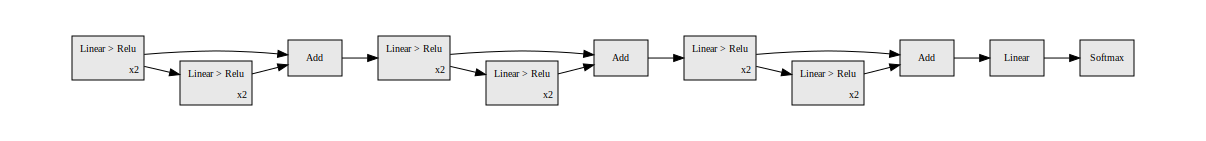

In [ ]:
mlp_skipper_cifar = MLP_skip_add(32*32*3)
mlp_skipper_cifar = mlp_skipper_cifar.to(device)
hl.build_graph(mlp_skipper_cifar, images)

###Training for Skipped

In [ ]:
# Training for MNIST
skipped_loss_mnist, skipped_acc_mnist = runner(mlp_skipper_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:09<03:31, 14.07s/it]

Epoch 5 - Training loss: 1.6107843683121053 - val_acc: 0.8561000227928162


 50%|█████     | 10/20 [02:21<02:22, 14.28s/it]

Epoch 10 - Training loss: 1.5166422214913875 - val_acc: 0.9456999897956848


 75%|███████▌  | 15/20 [03:32<01:11, 14.20s/it]

Epoch 15 - Training loss: 1.4984861028955339 - val_acc: 0.9498999714851379


100%|██████████| 20/20 [04:43<00:00, 14.17s/it]

Epoch 20 - Training loss: 1.4913886151415237 - val_acc: 0.9631999731063843


In [ ]:
# Training for CIFAR10
skipped_loss_cifar, skipped_acc_cifar = runner(mlp_skipper_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:27<04:27, 17.82s/it]

Epoch 5 - Training loss: 2.1351085816110884 - val_acc: 0.3215000033378601


 50%|█████     | 10/20 [02:59<03:02, 18.24s/it]

Epoch 10 - Training loss: 2.0797773794252046 - val_acc: 0.36309999227523804


 75%|███████▌  | 15/20 [04:31<01:32, 18.51s/it]

Epoch 15 - Training loss: 2.0546304279444167 - val_acc: 0.4074999988079071


100%|██████████| 20/20 [06:02<00:00, 18.12s/it]

Epoch 20 - Training loss: 2.0278903385814355 - val_acc: 0.4189000129699707


##Comparison

Plotting Accuracy and Loss for both MNIST and CIFAR10

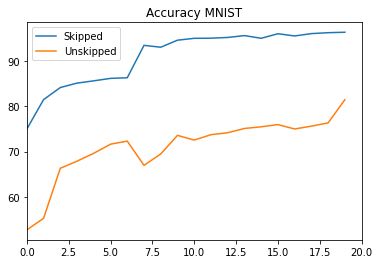

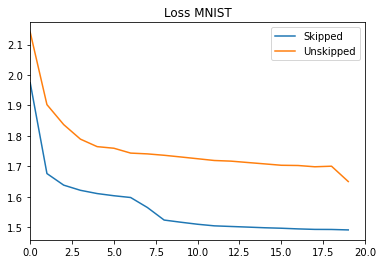

In [ ]:
plt.figure('Accuracy MNIST')
plt.title('Accuracy MNIST')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_acc_mnist], label = 'Skipped')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in unskipped_acc_mnist], label = 'Unskipped')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss MNIST')
plt.title('Loss MNIST')

plt.plot(skipped_loss_mnist, label = 'Skipped')
plt.plot(unskipped_loss_mnist, label = 'Unskipped')

plt.xlim(0, 20)

plt.legend()
plt.show()

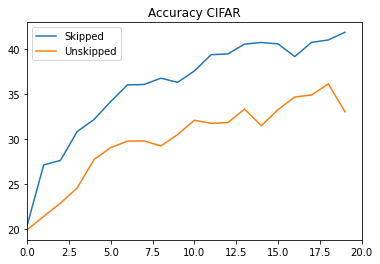

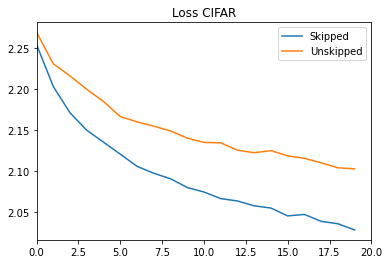

In [ ]:
plt.figure('Accuracy CIFAR')
plt.title('Accuracy CIFAR')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_acc_cifar], label = 'Skipped')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in unskipped_acc_cifar], label = 'Unskipped')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss CIFAR')
plt.title('Loss CIFAR')

plt.plot(skipped_loss_cifar, label = 'Skipped')
plt.plot(unskipped_loss_cifar, label = 'Unskipped')

plt.xlim(0, 20)

plt.legend()
plt.show()

##Observations

Model with Skipped connections preforms much better in both Loss and Accuracy than Unskipped.

# Part 2 - Analyse multiple different types of skip connections

We have compared three types of skip connections:

- Type 1 - Simple Additive Summation - The output of a previous layer is added to the output of a following deeper layer. These can be applied over layers with same size.
- Type 2 - Concatenation    - Here the vectors are concatenated and passed onto further layers.
- Type 3 - Projection + Summation  - This is a similar type to Type 1 but here we can have a connection between layers with different size too, which can be done by having a learnable matrix W in the skip connection so that the skip vector V is multiplied to W to get a projection in smaller number of dimensions and can be used.

We have already shown Type 1 in Part 1. 

We train the Type 2 and a combination of Type 1 and Type 3 here, and compare the three experiments.

### Declaring Model Classes

In [ ]:
class MLP_Skip_Concat(torch.nn.Module):
  
    def __init__(self,input_size):
        super(MLP_Skip_Concat, self).__init__()
        self.fc1 = torch.nn.Linear(input_size,256)
        self.fc2 = torch.nn.Linear(256,256)
        self.fc3 = torch.nn.Linear(256,256)
        self.fc4 = torch.nn.Linear(256,256)
        self.fc5 = torch.nn.Linear(512,128)
        self.fc6 = torch.nn.Linear(128,128)
        self.fc7 = torch.nn.Linear(128,128)
        self.fc8 = torch.nn.Linear(128,128)
        self.fc9 = torch.nn.Linear(256,64)
        self.fc10 = torch.nn.Linear(64,64)
        self.fc11 = torch.nn.Linear(64,64)
        self.fc12 = torch.nn.Linear(64,64)
        self.fc13 = torch.nn.Linear(128,10)

    def forward(self, x):
        output = x
        output = torch.nn.functional.relu(self.fc1(output))
        output = torch.nn.functional.relu(self.fc2(output))
        res1 = output
        output = torch.nn.functional.relu(self.fc3(output))
        output = torch.nn.functional.relu(self.fc4(output))
        output = torch.cat((output,res1), 1)
        output = torch.nn.functional.relu(self.fc5(output))
        output = torch.nn.functional.relu(self.fc6(output))
        res2 = output
        output = torch.nn.functional.relu(self.fc7(output))
        output = torch.nn.functional.relu(self.fc8(output))
        output = torch.cat((output,res2), 1)
        output = torch.nn.functional.relu(self.fc9(output))
        output = torch.nn.functional.relu(self.fc10(output))
        res3 = output
        output = torch.nn.functional.relu(self.fc11(output))
        output = torch.nn.functional.relu(self.fc12(output))
        output = torch.cat((output,res3), 1)
        output = torch.nn.functional.softmax(self.fc13(output))
        return output

In [ ]:
class MLP_Skip_Hybrid(torch.nn.Module):
  
    def __init__(self, input_size):
        super(MLP_Skip_Hybrid, self).__init__()
        self.fc1 = torch.nn.Linear(input_size,256)
        self.fc2= torch.nn.Linear(256,256)
        self.fc3 = torch.nn.Linear(256,256)
        self.fc4 = torch.nn.Linear(256,256)
        self.fc5 = torch.nn.Linear(256,128)
        self.fc6 = torch.nn.Linear(128,128)
        self.fc7 = torch.nn.Linear(128,128)
        self.fc8 = torch.nn.Linear(128,128)
        self.fc9 = torch.nn.Linear(128,64)
        self.fc10 = torch.nn.Linear(64,64)
        self.fc11 = torch.nn.Linear(64,64)
        self.fc12 = torch.nn.Linear(64,64)
        self.fc13 = torch.nn.Linear(64,10)
        self.residualConnection1= torch.nn.Linear(256,128,bias=False)
        self.residualConnection2= torch.nn.Linear(128,64,bias=False)
    def forward(self, x):
        output = x
        output = torch.nn.functional.relu(self.fc1(output))
        output = torch.nn.functional.relu(self.fc2(output))
        residueTypeI1 = output
        output = torch.nn.functional.relu(self.fc3(output))
        output = torch.nn.functional.relu(self.fc4(output))
        output = output + residueTypeI1
        residueTypeII1 = torch.nn.functional.relu(self.residualConnection1(output)) 
        output = torch.nn.functional.relu(self.fc5(output))
        output = torch.nn.functional.relu(self.fc6(output))
        output = output+residueTypeII1
        residueTypeI2 = output
        output = torch.nn.functional.relu(self.fc7(output))
        output = torch.nn.functional.relu(self.fc8(output))
        output = output + residueTypeI2
        residueTypeII2 = torch.nn.functional.relu(self.residualConnection2(output))
        output = torch.nn.functional.relu(self.fc9(output+residueTypeI2))
        output = torch.nn.functional.relu(self.fc10(output))
        output = output+ residueTypeII2
        residueTypeI3 = output
        output = torch.nn.functional.relu(self.fc11(output))
        output = torch.nn.functional.relu(self.fc12(output))
        
        output = torch.nn.functional.softmax(self.fc13(output+residueTypeI3), dim = 1)
        return output

###Initializing Concatenated Skip Connections

In [ ]:
skipper_concat_mnist = MLP_Skip_Concat(28*28*1)
skipper_concat_mnist = skipper_concat_mnist.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


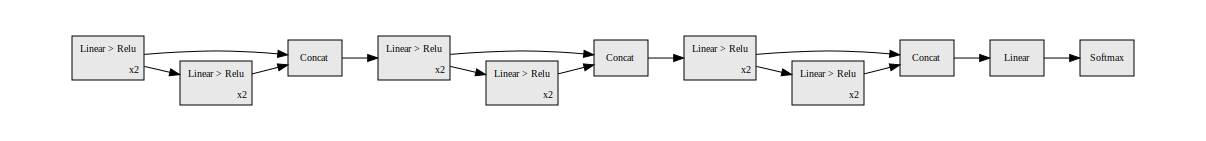

In [ ]:
skipper_concat_cifar = MLP_Skip_Concat(32*32*3)
skipper_concat_cifar = skipper_concat_cifar.to(device)
hl.build_graph(skipper_concat_cifar, images)

###Initializing Hybrid Skip Connections

In [ ]:
skipper_hybrid_mnist = MLP_Skip_Hybrid(28*28*1)
skipper_hybrid_mnist = skipper_hybrid_mnist.to(device)

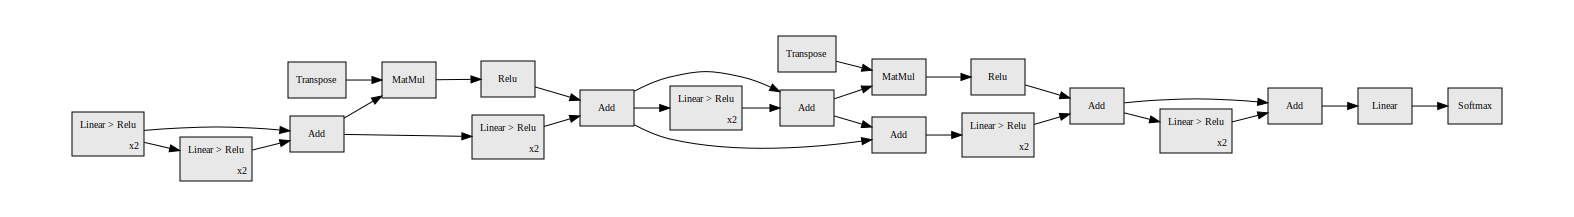

In [ ]:
skipper_hybrid_cifar = MLP_Skip_Hybrid(32*32*3)
skipper_hybrid_cifar = skipper_hybrid_cifar.to(device)
hl.build_graph(skipper_hybrid_cifar, images)

###Training Concatenated models

In [ ]:
# Training for MNIST
skipped_concat_loss_mnist, skipped_concat_acc_mnist = runner(skipper_concat_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:14<03:44, 14.98s/it]

Epoch 5 - Training loss: 1.6206503157920025 - val_acc: 0.8435999751091003


 50%|█████     | 10/20 [02:28<02:28, 14.85s/it]

Epoch 10 - Training loss: 1.5956628561019897 - val_acc: 0.866100013256073


 75%|███████▌  | 15/20 [03:44<01:15, 15.06s/it]

Epoch 15 - Training loss: 1.5084979939968028 - val_acc: 0.9483000040054321


100%|██████████| 20/20 [04:59<00:00, 14.95s/it]

Epoch 20 - Training loss: 1.4975248524483213 - val_acc: 0.9575999975204468


In [ ]:
# Training for CIFAR10
skipped_concat_loss_cifar, skipped_concat_acc_cifar = runner(skipper_concat_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:29<04:35, 18.35s/it]

Epoch 5 - Training loss: 2.1655742988294486 - val_acc: 0.2840000092983246


 50%|█████     | 10/20 [03:03<03:07, 18.73s/it]

Epoch 10 - Training loss: 2.0963330585129407 - val_acc: 0.34779998660087585


 75%|███████▌  | 15/20 [04:36<01:33, 18.63s/it]

Epoch 15 - Training loss: 2.0695367571042507 - val_acc: 0.39739999175071716


100%|██████████| 20/20 [06:11<00:00, 18.56s/it]

Epoch 20 - Training loss: 2.0439931196825847 - val_acc: 0.4214000105857849


###Training Hybrid Models

In [ ]:
# Training for MNIST
skipped_hybrid_loss_mnist, skipped_hybrid_acc_mnist = runner(skipper_hybrid_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:13<03:41, 14.79s/it]

Epoch 5 - Training loss: 1.6993649325472244 - val_acc: 0.7635999917984009


 50%|█████     | 10/20 [02:27<02:27, 14.78s/it]

Epoch 10 - Training loss: 1.5842241738704925 - val_acc: 0.8654999732971191


 75%|███████▌  | 15/20 [03:42<01:14, 14.93s/it]

Epoch 15 - Training loss: 1.5720821071178355 - val_acc: 0.8783000111579895


100%|██████████| 20/20 [04:56<00:00, 14.80s/it]

Epoch 20 - Training loss: 1.481344044969437 - val_acc: 0.9699000120162964


In [ ]:
# Training for CIFAR10
skipped_hybrid_loss_cifar, skipped_hybrid_acc_cifar = runner(skipper_hybrid_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:29<04:34, 18.33s/it]

Epoch 5 - Training loss: 2.100034561692452 - val_acc: 0.3619999885559082


 50%|█████     | 10/20 [03:03<03:07, 18.71s/it]

Epoch 10 - Training loss: 2.0592492800586077 - val_acc: 0.38359999656677246


 75%|███████▌  | 15/20 [04:37<01:33, 18.70s/it]

Epoch 15 - Training loss: 2.0329931913589943 - val_acc: 0.40700000524520874


100%|██████████| 20/20 [06:11<00:00, 18.57s/it]

Epoch 20 - Training loss: 2.0036938871656145 - val_acc: 0.44209998846054077


##Comparison

Plotting Accuracy and Loss for both MNIST and CIFAR10

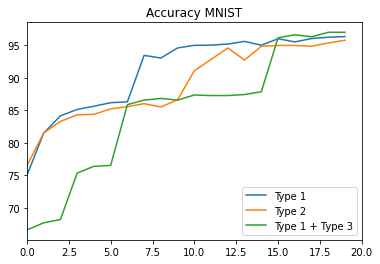

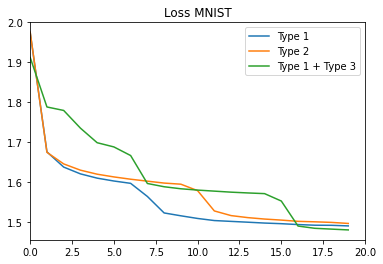

In [ ]:
plt.figure('Accuracy MNIST')
plt.title('Accuracy MNIST')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_acc_mnist], label = 'Type 1')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_concat_acc_mnist], label = 'Type 2')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_hybrid_acc_mnist], label = 'Type 1 + Type 3')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss MNIST')
plt.title('Loss MNIST')

plt.plot(skipped_loss_mnist, label = 'Type 1')
plt.plot(skipped_concat_loss_mnist, label = 'Type 2')
plt.plot(skipped_hybrid_loss_mnist, label = 'Type 1 + Type 3')

plt.xlim(0, 20)

plt.legend()
plt.show()

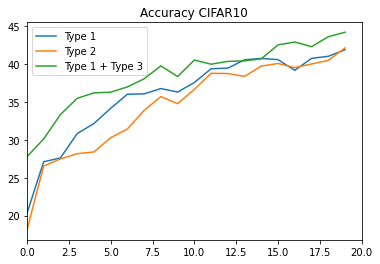

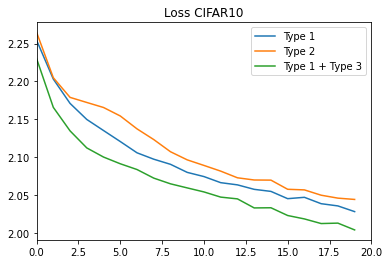

In [ ]:
plt.figure('Accuracy CIFAR10')
plt.title('Accuracy CIFAR10')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_acc_cifar], label = 'Type 1')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_concat_acc_cifar], label = 'Type 2')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_hybrid_acc_cifar], label = 'Type 1 + Type 3')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss CIFAR10')
plt.title('Loss CIFAR10')

plt.plot(skipped_loss_cifar, label = 'Type 1')
plt.plot(skipped_concat_loss_cifar, label = 'Type 2')
plt.plot(skipped_hybrid_loss_cifar, label = 'Type 1 + Type 3')

plt.xlim(0, 20)

plt.legend()
plt.show()

##Observations

We found that the combination of Type 1 and Type 3 reduces the loss the fastest, and that Type 1 is faster than Type 2. 

Hence, the accuracy of Type 1 + Type 3 increases the fastest. 
Type 1 and Type 2 were found to give similar performance in terms of accuracy, even though Type 1 loss was lower.




#Part 3 - Perform ablation studies over different characteristics of skip connections.



## Number of skip connections.

Here our model is a 13 layer MLP. The model class MLP_sss takes a three character string which represents the absence or presence of skip connections in the block of similar sized layers.

U - denotes an unskipped connection.

S - denoted a skipped conncection.

In [ ]:
class MLP_sss(torch.nn.Module):
  
    def __init__(self, input_size, s):
        super(MLP_sss, self).__init__()
        self.fc1 = torch.nn.Linear(input_size,256)
        self.fc2 = torch.nn.Linear(256,256)
        self.fc3 = torch.nn.Linear(256,256)
        self.fc4 = torch.nn.Linear(256,256)
        self.fc5 = torch.nn.Linear(256,128)
        self.fc6 = torch.nn.Linear(128,128)
        self.fc7 = torch.nn.Linear(128,128)
        self.fc8 = torch.nn.Linear(128,128)
        self.fc9 = torch.nn.Linear(128,64)
        self.fc10 = torch.nn.Linear(64,64)
        self.fc11 = torch.nn.Linear(64,64)
        self.fc12 = torch.nn.Linear(64,64)
        self.fc13 = torch.nn.Linear(64,10)

        self.s = s

    def forward(self, x):
        output = x
        output = torch.nn.functional.relu(self.fc1(output))
        output = torch.nn.functional.relu(self.fc2(output))
        if self.s[0] == 's':
          res1 = output
        output = torch.nn.functional.relu(self.fc3(output))
        output = torch.nn.functional.relu(self.fc4(output))
        if self.s[0] == 's':
          output += res1
        output = torch.nn.functional.relu(self.fc5(output))
        output = torch.nn.functional.relu(self.fc6(output))
        if self.s[1] == 's':
          res2 = output
        output = torch.nn.functional.relu(self.fc7(output))
        output = torch.nn.functional.relu(self.fc8(output))
        if self.s[1] == 's':
          output += res2
        output = torch.nn.functional.relu(self.fc9(output))
        output = torch.nn.functional.relu(self.fc10(output))
        if self.s[2] == 's':
          res3 = output
        output = torch.nn.functional.relu(self.fc11(output))
        output = torch.nn.functional.relu(self.fc12(output))
        if self.s[2] == 's':
          output += res3
        output = torch.nn.functional.softmax(self.fc13(output), dim = 1)
        return output

####Initializing and Training for 'USS'

In [ ]:
mlp_uss_mnist = MLP_sss(28*28*1 ,'uss')
mlp_uss_mnist = mlp_uss_mnist.to(device)

In [ ]:
uss_loss_mnist, uss_acc_mnist = runner(mlp_uss_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:11<03:35, 14.39s/it]

Epoch 5 - Training loss: 1.5803477444547287 - val_acc: 0.8899999856948853


 50%|█████     | 10/20 [02:24<02:25, 14.53s/it]

Epoch 10 - Training loss: 1.5332317108803608 - val_acc: 0.9222999811172485


 75%|███████▌  | 15/20 [03:36<01:12, 14.47s/it]

Epoch 15 - Training loss: 1.5151939615290215 - val_acc: 0.9361000061035156


100%|██████████| 20/20 [04:49<00:00, 14.48s/it]

Epoch 20 - Training loss: 1.5061232926997732 - val_acc: 0.9427000284194946


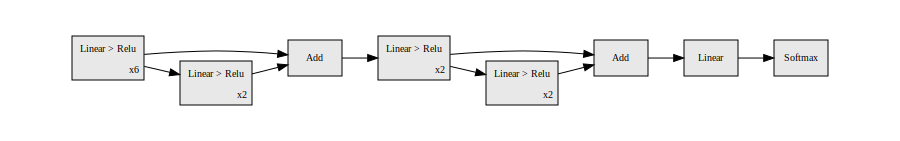

In [ ]:
mlp_uss_cifar = MLP_sss(32*32*3 ,'uss')
mlp_uss_cifar = mlp_uss_cifar.to(device)
hl.build_graph(mlp_uss_cifar, images)

In [ ]:
uss_loss_cifar, uss_acc_cifar = runner(mlp_uss_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:26<04:24, 17.61s/it]

Epoch 5 - Training loss: 2.16798732840285 - val_acc: 0.2953000068664551


 50%|█████     | 10/20 [02:57<03:00, 18.04s/it]

Epoch 10 - Training loss: 2.0952043557653623 - val_acc: 0.3515999913215637


 75%|███████▌  | 15/20 [04:28<01:30, 18.18s/it]

Epoch 15 - Training loss: 2.066794532902387 - val_acc: 0.38119998574256897


100%|██████████| 20/20 [05:58<00:00, 17.94s/it]

Epoch 20 - Training loss: 2.049018142782912 - val_acc: 0.4099999964237213


####Initializing and Training for 'UUS'

In [ ]:
mlp_uus_mnist = MLP_sss(28*28*1 ,'uus')
mlp_uus_mnist = mlp_uus_mnist.to(device)

In [ ]:
uus_loss_mnist, uus_acc_mnist = runner(mlp_uus_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:11<03:34, 14.29s/it]

Epoch 5 - Training loss: 1.733388816549423 - val_acc: 0.7304999828338623


 50%|█████     | 10/20 [02:23<02:24, 14.46s/it]

Epoch 10 - Training loss: 1.617881584674754 - val_acc: 0.805899977684021


 75%|███████▌  | 15/20 [03:35<01:12, 14.46s/it]

Epoch 15 - Training loss: 1.6025512558348636 - val_acc: 0.8436999917030334


100%|██████████| 20/20 [04:47<00:00, 14.40s/it]

Epoch 20 - Training loss: 1.5942799405848727 - val_acc: 0.859000027179718


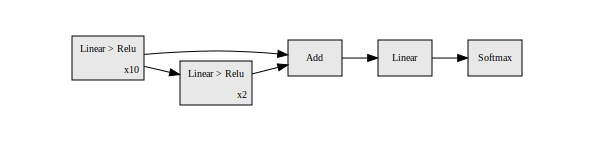

In [ ]:
mlp_uus_cifar = MLP_sss(32*32*3 ,'uus')
mlp_uus_cifar = mlp_uus_cifar.to(device)
hl.build_graph(mlp_uus_cifar, images)

In [ ]:
uus_loss_cifar, uus_acc_cifar = runner(mlp_uus_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:26<04:24, 17.61s/it]

Epoch 5 - Training loss: 2.166983974223234 - val_acc: 0.28130000829696655


 50%|█████     | 10/20 [02:56<02:59, 17.97s/it]

Epoch 10 - Training loss: 2.1275306757615535 - val_acc: 0.33390000462532043


 75%|███████▌  | 15/20 [04:26<01:29, 17.86s/it]

Epoch 15 - Training loss: 2.1006901191205394 - val_acc: 0.3711000084877014


100%|██████████| 20/20 [05:56<00:00, 17.83s/it]

Epoch 20 - Training loss: 2.0813456433159963 - val_acc: 0.3750999867916107


####Initializing and Training for 'SUS'

In [ ]:
mlp_sus_mnist = MLP_sss(28*28*1 ,'sus')
mlp_sus_mnist = mlp_sus_mnist.to(device)

In [ ]:
sus_loss_mnist, sus_acc_mnist = runner(mlp_sus_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:10<03:32, 14.18s/it]

Epoch 5 - Training loss: 1.7130698193895055 - val_acc: 0.7436000108718872


 50%|█████     | 10/20 [02:23<02:25, 14.54s/it]

Epoch 10 - Training loss: 1.6142615800208233 - val_acc: 0.8320000171661377


 75%|███████▌  | 15/20 [03:35<01:11, 14.29s/it]

Epoch 15 - Training loss: 1.5950073343642215 - val_acc: 0.8532000184059143


100%|██████████| 20/20 [04:47<00:00, 14.39s/it]

Epoch 20 - Training loss: 1.5872013355823273 - val_acc: 0.8601999878883362


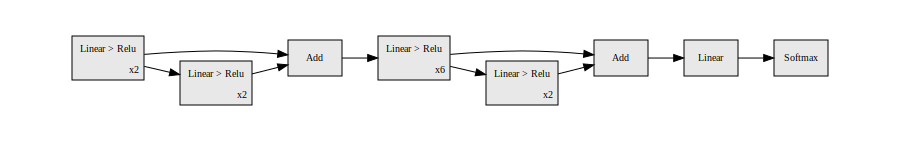

In [ ]:
mlp_sus_cifar = MLP_sss(32*32*3 ,'sus')
mlp_sus_cifar = mlp_sus_cifar.to(device)
hl.build_graph(mlp_sus_cifar, images)

In [ ]:
sus_loss_cifar, sus_acc_cifar = runner(mlp_sus_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:26<04:24, 17.65s/it]

Epoch 5 - Training loss: 2.1606872556160908 - val_acc: 0.2994999885559082


 50%|█████     | 10/20 [02:59<03:03, 18.31s/it]

Epoch 10 - Training loss: 2.108986089424211 - val_acc: 0.33570000529289246


 75%|███████▌  | 15/20 [04:30<01:31, 18.29s/it]

Epoch 15 - Training loss: 2.07249074566121 - val_acc: 0.38499999046325684


100%|██████████| 20/20 [06:01<00:00, 18.09s/it]

Epoch 20 - Training loss: 2.046818125612882 - val_acc: 0.3905999958515167


####Initializing and Training for 'SSU'

In [ ]:
mlp_ssu_mnist = MLP_sss(28*28*1 ,'ssu')
mlp_ssu_mnist = mlp_ssu_mnist.to(device)

In [ ]:
ssu_loss_mnist, ssu_acc_mnist = runner(mlp_ssu_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:11<03:34, 14.32s/it]

Epoch 5 - Training loss: 1.6764579509166961 - val_acc: 0.8700000047683716


 50%|█████     | 10/20 [02:23<02:23, 14.36s/it]

Epoch 10 - Training loss: 1.5194829864704862 - val_acc: 0.9358999729156494


 75%|███████▌  | 15/20 [03:35<01:12, 14.49s/it]

Epoch 15 - Training loss: 1.5036526005318824 - val_acc: 0.9521999955177307


100%|██████████| 20/20 [04:48<00:00, 14.42s/it]

Epoch 20 - Training loss: 1.4976193088166256 - val_acc: 0.9577999711036682


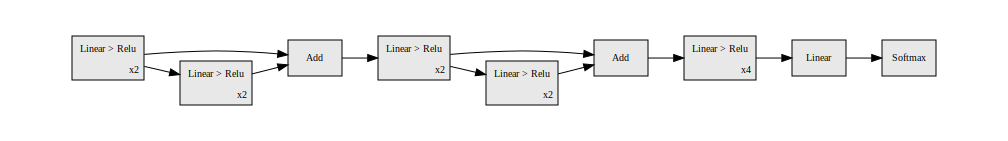

In [ ]:
mlp_ssu_cifar = MLP_sss(32*32*3 ,'ssu')
mlp_ssu_cifar = mlp_ssu_cifar.to(device)
hl.build_graph(mlp_ssu_cifar, images)

In [ ]:
ssu_loss_cifar, ssu_acc_cifar = runner(mlp_ssu_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:28<04:29, 17.95s/it]

Epoch 5 - Training loss: 2.169813738793743 - val_acc: 0.26739999651908875


 50%|█████     | 10/20 [02:59<03:02, 18.27s/it]

Epoch 10 - Training loss: 2.1297342315012093 - val_acc: 0.334199994802475


 75%|███████▌  | 15/20 [04:31<01:31, 18.23s/it]

Epoch 15 - Training loss: 2.1054414157964745 - val_acc: 0.3521000146865845


100%|██████████| 20/20 [06:03<00:00, 18.16s/it]

Epoch 20 - Training loss: 2.0738636285674814 - val_acc: 0.3709999918937683


###Comparison

Plotting Accuracy and Loss for both MNIST and CIFAR10

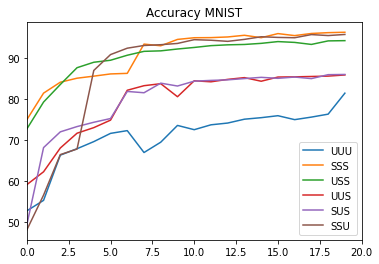

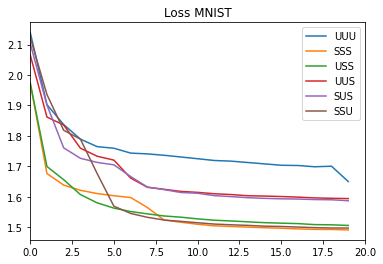

In [66]:
plt.figure('Accuracy')
plt.title('Accuracy MNIST')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in unskipped_acc_mnist], label = 'UUU')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_acc_mnist], label = 'SSS')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in uss_acc_mnist], label = 'USS')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in uus_acc_mnist], label = 'UUS')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in sus_acc_mnist], label = 'SUS')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in ssu_acc_mnist], label = 'SSU')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss')
plt.title('Loss MNIST')

plt.plot(unskipped_loss_mnist, label = 'UUU')
plt.plot(skipped_loss_mnist, label = 'SSS')
plt.plot(uss_loss_mnist, label = 'USS')
plt.plot(uus_loss_mnist, label = 'UUS')
plt.plot(sus_loss_mnist, label = 'SUS')
plt.plot(ssu_loss_mnist, label = 'SSU')

plt.xlim(0, 20)

plt.legend()
plt.show()

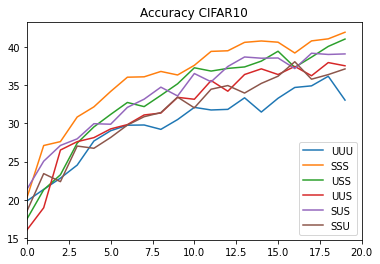

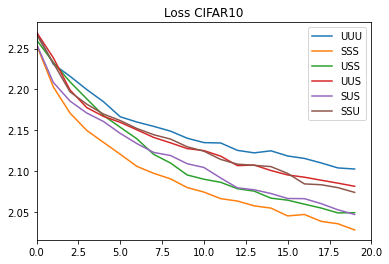

In [65]:
plt.figure('Accuracy')
plt.title('Accuracy CIFAR10')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in unskipped_acc_cifar], label = 'UUU')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_acc_cifar], label = 'SSS')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in uss_acc_cifar], label = 'USS')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in uus_acc_cifar], label = 'UUS')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in sus_acc_cifar], label = 'SUS')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in ssu_acc_cifar], label = 'SSU')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss')
plt.title('Loss CIFAR10')

plt.plot(unskipped_loss_cifar, label = 'UUU')
plt.plot(skipped_loss_cifar, label = 'SSS')
plt.plot(uss_loss_cifar, label = 'USS')
plt.plot(uus_loss_cifar, label = 'UUS')
plt.plot(sus_loss_cifar, label = 'SUS')
plt.plot(ssu_loss_cifar, label = 'SSU')

plt.xlim(0, 20)

plt.legend()
plt.show()

###Observations

UUU, the model with no skip connection performed the worst, in both accuracy, as well as loss, for both datasets.

Whereas, SSS performed the best in both Loss and Accuracy, over both datasets.

In general, we saw that the models with more skip connections, saw better performance overall.

USS performed the best consistently in comparision to SUS and SSU, which tells us that deeper skip connections give better results.

## Number of layers skipped

Here is a 11 layered MLP generator, which takes in a two character string, which denoted the number of layers skipped in each occasion. The original structure was changed to support this experiment.

In [ ]:
class MLP_gap(torch.nn.Module):
  
    def __init__(self, inputsize, s):

        super(MLP_gap, self).__init__()
        self.fc1 = torch.nn.Linear(inputsize,256)
        self.fc2 = torch.nn.Linear(256,256)
        self.fc3 = torch.nn.Linear(256,256)
        self.fc4 = torch.nn.Linear(256,256)
        self.fc5 = torch.nn.Linear(256,256)
        self.fc6 = torch.nn.Linear(256,256)
        self.fc7 = torch.nn.Linear(256,64)
        self.fc8 = torch.nn.Linear(64,64)
        self.fc9 = torch.nn.Linear(64,64)
        self.fc10 = torch.nn.Linear(64,64)
        self.fc11 = torch.nn.Linear(64,10)

        self.s = s

    def forward(self, x):
        output = x
        output = torch.nn.functional.relu(self.fc1(output))
        output = torch.nn.functional.relu(self.fc2(output))
        res1 = output
        output = torch.nn.functional.relu(self.fc3(output))
        output = torch.nn.functional.relu(self.fc4(output))
        if self.s[0] == '2':                              
          output += res1
        output = torch.nn.functional.relu(self.fc5(output))
        if self.s[0] == '3':
          output += res1
        output = torch.nn.functional.relu(self.fc6(output))
        output = torch.nn.functional.relu(self.fc7(output))
        if self.s[1] == '3':
          res2 = output
        output = torch.nn.functional.relu(self.fc8(output))
        if self.s[1] == '2':
          res2 = output
        output = torch.nn.functional.relu(self.fc9(output))
        output = torch.nn.functional.relu(self.fc10(output))
        output += res2
        output = torch.nn.functional.softmax(self.fc11(output), dim = 1)
        return output

###Initializing and Training '22'

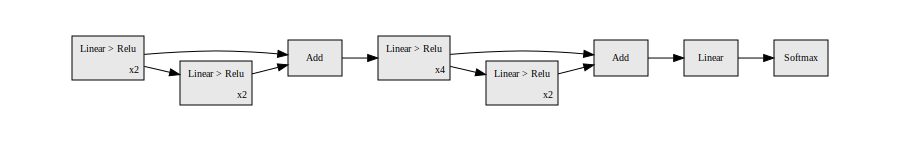

In [ ]:
mlp_gap22_mnist = MLP_gap(28*28*1, '22')
mlp_gap22_mnist = mlp_gap22_mnist.to(device)

mlp_gap22_cifar = MLP_gap(32*32*3, '22')
mlp_gap22_cifar = mlp_gap22_cifar.to(device)

hl.build_graph(mlp_gap22_cifar, images)

In [ ]:
s22_loss_mnist, s22_acc_mnist = runner(mlp_gap22_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:12<03:39, 14.65s/it]

Epoch 5 - Training loss: 1.5565276851045324 - val_acc: 0.902400016784668


 50%|█████     | 10/20 [02:26<02:27, 14.78s/it]

Epoch 10 - Training loss: 1.518676125242355 - val_acc: 0.9363999962806702


 75%|███████▌  | 15/20 [03:40<01:14, 14.83s/it]

Epoch 15 - Training loss: 1.503560484723842 - val_acc: 0.9502000212669373


100%|██████████| 20/20 [04:55<00:00, 14.77s/it]

Epoch 20 - Training loss: 1.4949936572541582 - val_acc: 0.9538999795913696


In [ ]:
s22_loss_cifar, s22_acc_cifar = runner(mlp_gap22_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:28<04:32, 18.18s/it]

Epoch 5 - Training loss: 2.148400756777549 - val_acc: 0.31679999828338623


 50%|█████     | 10/20 [03:00<03:03, 18.31s/it]

Epoch 10 - Training loss: 2.0794484396370088 - val_acc: 0.37599998712539673


 75%|███████▌  | 15/20 [04:33<01:32, 18.55s/it]

Epoch 15 - Training loss: 2.0444433324191036 - val_acc: 0.4099999964237213


100%|██████████| 20/20 [06:05<00:00, 18.29s/it]

Epoch 20 - Training loss: 2.022419200259812 - val_acc: 0.4390000104904175


###Initializing and Training '32'

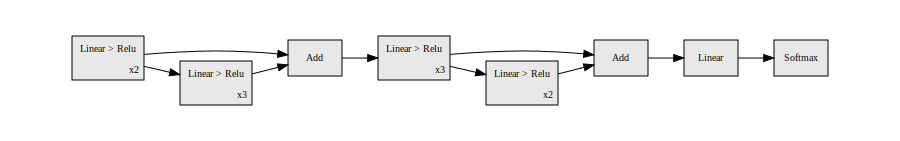

In [ ]:
mlp_gap32_mnist = MLP_gap(28*28*1, '32')
mlp_gap32_mnist = mlp_gap22_mnist.to(device)

mlp_gap32_cifar = MLP_gap(32*32*3, '32')
mlp_gap32_cifar = mlp_gap32_cifar.to(device)

hl.build_graph(mlp_gap32_cifar, images)

In [ ]:
s32_loss_mnist, s32_acc_mnist = runner(mlp_gap32_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:12<03:38, 14.55s/it]

Epoch 5 - Training loss: 1.49080843773294 - val_acc: 0.9563999772071838


 50%|█████     | 10/20 [02:26<02:27, 14.70s/it]

Epoch 10 - Training loss: 1.4867139237992306 - val_acc: 0.9607999920845032


 75%|███████▌  | 15/20 [03:41<01:15, 15.08s/it]

Epoch 15 - Training loss: 1.4840479424659243 - val_acc: 0.9656999707221985


100%|██████████| 20/20 [05:00<00:00, 15.04s/it]

Epoch 20 - Training loss: 1.4820373195282956 - val_acc: 0.9672999978065491


In [ ]:
s32_loss_cifar, s32_acc_cifar = runner(mlp_gap32_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:27<04:26, 17.76s/it]

Epoch 5 - Training loss: 2.1145933671873443 - val_acc: 0.3472999930381775


 50%|█████     | 10/20 [02:58<03:02, 18.24s/it]

Epoch 10 - Training loss: 2.072339208758607 - val_acc: 0.3831000030040741


 75%|███████▌  | 15/20 [04:29<01:31, 18.27s/it]

Epoch 15 - Training loss: 2.0438556567746766 - val_acc: 0.4115000069141388


100%|██████████| 20/20 [06:01<00:00, 18.06s/it]

Epoch 20 - Training loss: 2.026865152071933 - val_acc: 0.42149999737739563


###Initializing and Training '33'

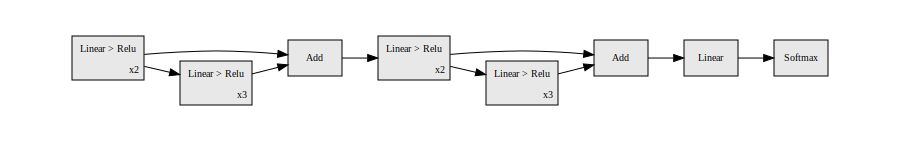

In [ ]:
mlp_gap33_mnist = MLP_gap(28*28*1, '33')
mlp_gap33_mnist = mlp_gap22_mnist.to(device)

mlp_gap33_cifar = MLP_gap(32*32*3, '33')
mlp_gap33_cifar = mlp_gap33_cifar.to(device)

hl.build_graph(mlp_gap33_cifar, images)

In [ ]:
s33_loss_mnist, s33_acc_mnist = runner(mlp_gap33_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [01:23<04:09, 16.66s/it]

Epoch 5 - Training loss: 1.4805642757009954 - val_acc: 0.9689000248908997


 50%|█████     | 10/20 [02:48<02:51, 17.12s/it]

Epoch 10 - Training loss: 1.4776692162168787 - val_acc: 0.9708999991416931


 75%|███████▌  | 15/20 [04:18<01:29, 17.82s/it]

Epoch 15 - Training loss: 1.4779452714514225 - val_acc: 0.9696999788284302


100%|██████████| 20/20 [05:55<00:00, 17.78s/it]

Epoch 20 - Training loss: 1.477580384497947 - val_acc: 0.9704999923706055


In [60]:
s33_loss_cifar, s33_acc_cifar = runner(mlp_gap33_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:26<04:23, 17.57s/it]

Epoch 5 - Training loss: 2.1034552394127357 - val_acc: 0.3580999970436096


 50%|█████     | 10/20 [02:58<03:02, 18.21s/it]

Epoch 10 - Training loss: 2.0646671737943376 - val_acc: 0.3935999870300293


 75%|███████▌  | 15/20 [04:29<01:31, 18.26s/it]

Epoch 15 - Training loss: 2.031748214546515 - val_acc: 0.41830000281333923


100%|██████████| 20/20 [06:00<00:00, 18.01s/it]

Epoch 20 - Training loss: 2.0049896818034503 - val_acc: 0.43779999017715454


###Comparison

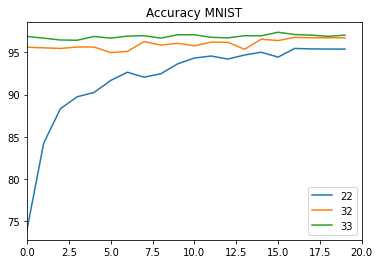

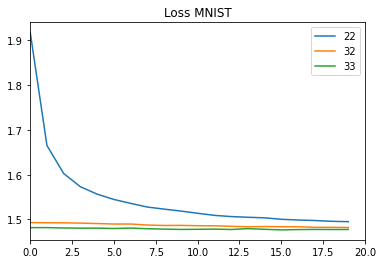

In [64]:
plt.figure('Accuracy MNIST')
plt.title('Accuracy MNIST')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in s22_acc_mnist], label = '22')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in s32_acc_mnist], label = '32')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in s33_acc_mnist], label = '33')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss')
plt.title('Loss MNIST')

plt.plot(s22_loss_mnist, label = '22')
plt.plot(s32_loss_mnist, label = '32')
plt.plot(s33_loss_mnist, label = '33')

plt.xlim(0, 20)

plt.legend()
plt.show()

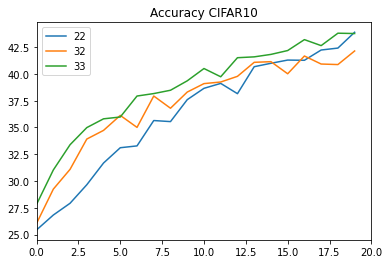

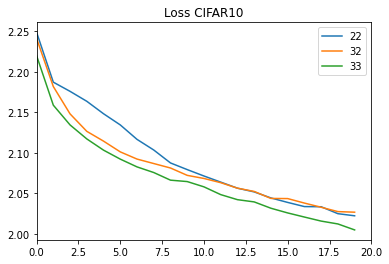

In [63]:
plt.figure('Accuracy')
plt.title('Accuracy CIFAR10')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in s22_acc_cifar], label = '22')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in s32_acc_cifar], label = '32')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in s33_acc_cifar], label = '33')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss')
plt.title('Loss CIFAR10')

plt.plot(s22_loss_cifar, label = '22')
plt.plot(s32_loss_cifar, label = '32')
plt.plot(s33_loss_cifar, label = '33')

plt.xlim(0, 20)

plt.legend()
plt.show()

###Observations

'33' performed the best in both datasets. We also observed that '33' and '32' did most of their learning in epoch 1 itself.

#BONUS

Hypothesis: Through a skip connection it is easier to realize an identity connection, by making weight and biases between the skip connections zero. This enables a deeper neural network to give an on-par performance to a comparatively shallow network.

In [68]:
mlp_shallow_mnist = MLP([784, 256, 128, 64, 10])
mlp_shallow_mnist = mlp_shallow_mnist.to(device)

In [72]:
mlp_shallow_cifar = MLP([32*32*3, 256, 128, 64, 10])
mlp_shallow_cifar = mlp_shallow_cifar.to(device)

In [69]:
shallow_loss_mnist, shallow_acc_mnist = runner(mlp_shallow_mnist, train_loader_MNIST, test_loader_MNIST)

 25%|██▌       | 5/20 [00:55<02:48, 11.21s/it]

Epoch 5 - Training loss: 1.6178287922067844 - val_acc: 0.8489999771118164


 50%|█████     | 10/20 [01:52<01:52, 11.22s/it]

Epoch 10 - Training loss: 1.5971439031844443 - val_acc: 0.8622999787330627


 75%|███████▌  | 15/20 [02:47<00:55, 11.17s/it]

Epoch 15 - Training loss: 1.5880727615762265 - val_acc: 0.8683000206947327


100%|██████████| 20/20 [03:44<00:00, 11.21s/it]

Epoch 20 - Training loss: 1.537207444170688 - val_acc: 0.9506999850273132


In [73]:
shallow_loss_cifar, shallow_acc_cifar = runner(mlp_shallow_cifar, train_loader_CIFAR10, test_loader_CIFAR10)

 25%|██▌       | 5/20 [01:15<03:49, 15.27s/it]

Epoch 5 - Training loss: 2.103964275243331 - val_acc: 0.3614000082015991


 50%|█████     | 10/20 [02:33<02:35, 15.51s/it]

Epoch 10 - Training loss: 2.0706981086001104 - val_acc: 0.3788999915122986


 75%|███████▌  | 15/20 [03:52<01:18, 15.71s/it]

Epoch 15 - Training loss: 2.045923330345932 - val_acc: 0.4092000126838684


100%|██████████| 20/20 [05:10<00:00, 15.54s/it]

Epoch 20 - Training loss: 2.0247034533899657 - val_acc: 0.4293999969959259


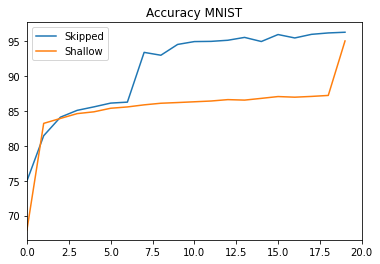

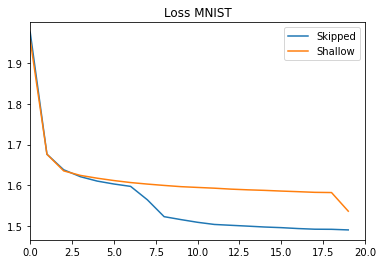

In [70]:
plt.figure('Accuracy MNIST')
plt.title('Accuracy MNIST')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_acc_mnist], label = 'Skipped')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in shallow_acc_mnist], label = 'Shallow')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss MNIST')
plt.title('Loss MNIST')

plt.plot(skipped_loss_mnist, label = 'Skipped')
plt.plot(shallow_loss_mnist, label = 'Shallow')

plt.xlim(0, 20)

plt.legend()
plt.show()

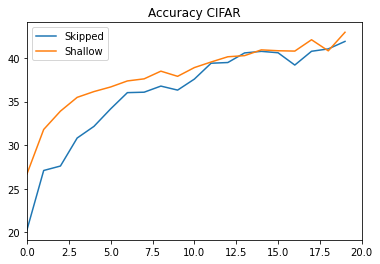

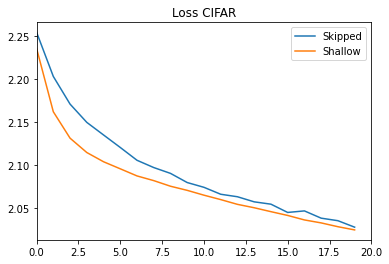

In [74]:
plt.figure('Accuracy CIFAR')
plt.title('Accuracy CIFAR')

plt.plot([i.to(torch.device('cpu')).mul(100) for i in skipped_acc_cifar], label = 'Skipped')
plt.plot([i.to(torch.device('cpu')).mul(100) for i in shallow_acc_cifar], label = 'Shallow')

plt.xlim(0, 20)
# plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure('Loss CIFAR')
plt.title('Loss CIFAR')

plt.plot(skipped_loss_cifar, label = 'Skipped')
plt.plot(shallow_loss_cifar, label = 'Shallow')

plt.xlim(0, 20)

plt.legend()
plt.show()

##Observations

The shallow and skipped models gave a similar results in both datasets.

#Probable Explanations for our observations

Reflecting to the hypothesis stated in the BONUS section and the Observations made in Part 1, we see that:


1.   Deep neural networks have higher training error over shallower ones.
2.   Given that skip connections help us realize identity connections, it can help make a deep neural network behave like a shallower one. Hence, reducing the training error.


It might also be that addition of skip connections increases the information available at hand to each layer, by addition of activations from previous layers.

It can also be seen that in case of CIFAR10, accuracy remains below 50%. This could be because different colour channels making the same pixel in the image are not being grouped together, which is not the case in MNIST.

